====================================================================================================================================

Prepared by
Chris Bennett


===============================================================================================================================

## Executive Summary

#### Business Problem

This analysis is based on data collected through the Behavioral Risk Factor Surveillance System (BRFSS), which is an annual statewide telephone survey conducted by Company X's Survey Business Unit. This work has been commissioned by the head of the Survey Busines Unit(SBU), and is aimed at creating a mechanism for detecting misrepresentation in the survey data set.

The critical issue is that the SBU believes that the validity of the survey data may be compromised as some respondents may intentionally misrepresent their health status for Diabetes.

#### Methodology and Summary of Key Findings

To identify potential misrepresentation, I developed two competing predictive machine-learning models based on other variables available on the respondents, namely Xgboost and Random Forest Models. This approach is based on the intuition that honest responses will be consistent with the other information we have on the respondents. This means, therefore, that significant differences between predicted statuses and actual survey responses may be indicative of a risk of misrepresention, which could then be used to inform other schemes for validating the accuracy of their responses ( for example, medical tests or medical records).

The Xgboost model yielded a slighly better predictive performance than the Random Forest model ( roc-auc = **93.48** vs roc-auc = **94.28**). Also, the Xgboost model generated an overall accuracy of **87%** with precision and recall of **86%** and **89% ** respectively. In addition, the Xgboost model produced a lift of approx. **1.69**, which means that the predictions of this classification is **1.69** times better than randomly-generated predictions. Also worthy of note is the fact that the roc-auc of the 10-fold validation model is approx. **94%** and the dimensionality of the dataset (i.e. the feature space) has been significantly reduced, from **120** features to **5** features.
Notably the **5** most important predictors of whether a person has diabetes or not in order of importance are given below :
1. AGE - Age of the respondent?
2. BMI5CAT - Computed body mass index categories?
3. GENHLTH - Would you say that in general your health is ?
4. HEALTHCL1 - (You said that a medical professional has told you that you have or have had a chronic illness. During the last 12   months, have you taken a course or class to teach you about how to manage problems related to (this/these) chronic illness(es)?
Have you ever attended a lifestyle change program, such as the diabetes Prevention Program, in order to improve your health or prevent diabetes?)
5. PDIABTST - Had a test for high blood sugar in past three years?

To investigate further improvements in the model, I recommended two strategies: **1.** Include other variables that highly predictive of Diabetes based on scientfic literature; and **2.** Conduct tuning of the hyper parameters of the Xgboost model to determine optimal performance.

The project is organized around five sections:

- Section 1: Data Importation and Exploration
- Section 2: Feature Engineering
- Section 3: Feature Selection
- Section 4: Comparing the Performance of Machine-learning Models
- Section 4: Extension of Logistic Regression Coefficients Model - Xgboost Model


## Section 1 : Data Importation and Exploration

#### 1.1 Importing key python libraries

In [ ]:
# to handle datasets
import pandas as pd
import numpy as np

# for text / string processing
import re

# for plotting
import matplotlib.pyplot as plt
% matplotlib inline

from pandas.tools.plotting import scatter_matrix
import seaborn as sns
sns.set_color_codes()
sns.set(font_scale=1.25)

# to divide train and test set
from sklearn.model_selection import train_test_split

# feature scaling
from sklearn.preprocessing import MinMaxScaler

# for tree binarisation
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score


# to build the models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

# Fitting SVM to the Training set
from sklearn.svm import SVC

# to evaluate the models
from sklearn.metrics import roc_auc_score
from sklearn import metrics
from sklearn.metrics import roc_curve, auc

# Fitting Naive Bayes to the Training set
from sklearn.naive_bayes import GaussianNB

# Fitting Neural Net to the Training set
from sklearn.neural_network import MLPClassifier

# Fitting K-Nearest Neighor  to the Training set
from sklearn.neighbors import KNeighborsClassifier

# Fitting Classification and Regression Trees  to the Training set
from sklearn.tree import DecisionTreeClassifier

#Classification Matrix
from sklearn.metrics import classification_report,confusion_matrix

pd.pandas.set_option('display.max_columns', None)
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel

import warnings
warnings.filterwarnings('ignore')

#### 1.2 Loading and exploring the dataset

In [71]:

# load dataset
data = pd.read_csv('SBU_example_Surveydata_2014.csv', encoding = "ISO-8859-1")


In [72]:
# Examining the first 3 rows of the dataset
data.head(3)

STATE  GEOSTR DENSTR2       PRECALL  REPNUM  REPDEPTH    FMONTH  \
0  New York     201       D  To be called   40136        28     April   
1  New York     202       D  To be called   10105        17   January   
2  New York     201       D  To be called  110014         4  November   

      IDATE    IMONTH  IDAY  IYEAR  DISPCODE       SEQNO         PSU  \
0   4252014         4    25   2014      1200  2014000012  2014000012   
1   3162014         3    16   2014      1200  2014000013  2014000013   
2  11292014  November    29   2014      1200  2014000014  2014000014   

   NATTMPTS  NRECSEL      NRECSTR PVTRESD1 COLGHOUS  STATERES CELLFON3  \
0         2    16600  14358760.86  Missing  Missing       NaN  Missing   
1         8    14544  13058665.94  Missing  Missing       NaN  Missing   
2         8    16600  14358760.86  Missing  Missing       NaN  Missing   

   LADULT  NUMADULT    GENHLTH        PHYSHLTH MENTHLTH              POORHLTH  \
0     NaN       NaN  Very good            None     None  Not asked or Missing   
1     NaN       NaN  Very good            None     None  Not asked or Missing   
2     NaN       NaN       Good  Number of days     None        Number of days   

  HLTHPLN1 EXERANY2                SLEPTIM1             CVDINFR4 CVDCRHD4  \
0      Yes       No  Number of hours [1-24]  Dont know/Not sure       No   
1      Yes      Yes  Number of hours [1-24]                   No       No   
2      Yes      Yes     Dont know/Not Sure                   No       No   

  CVDSTRK3 ASTHMA3               ASTHNOW CHCSCNCR CHCOCNCR CHCCOPD HAVARTH3  \
0       No      No  Not asked or Missing       No       No     Yes      Yes   
1       No      No  Not asked or Missing       No       No      No       No   
2       No      No  Not asked or Missing       No       No      No       No   

  ADDEPEV2 CHCKIDNY DIABETE3              AGE   MARITAL            CHILDREN  \
0       No       No       No  Age 65 or older  Divorced  Number of children   
1       No      Yes       No  Age 65 or older  Divorced                None   
2       No       No       No      Age 35 - 44   Married  Number of children   

                                               EDUCA    EMPLOY1  \
0  College 1 year to 3 years (Some college or tec...    Retired   
1         College 4 years or more (College graduate)    Retired   
2         College 4 years or more (College graduate)  A student   

                                         INCOME2 WEIGHT2 HEIGHT3  CTYCODE1  \
0                            Dont know/Not sure       D       D       NaN   
1  Less than $50000 ($35000 to less than $50000)       D       D       NaN   
2                                 $75000 or more       D       D       NaN   

  ZIPCODE     SEX              PREGNANT QLACTLM2 USEEQUIP BLIND DECIDE  \
0     DSU    Male  Not asked or Missing      Yes       No    No     No   
1     DSU  Female  Not asked or Missing       No       No    No     No   
2     DSU  Female                    No       No       No    No     No   

  DIFFWALK DIFFDRES DIFFALON     USENOW3                    ALCDAY5  \
0      Yes       No       No  Not at all  No drinks in past 30 days   
1       No       No       No  Not at all  No drinks in past 30 days   
2       No       No       No  Not at all              Days per week   

               FLSHTMY2              PNEUVAC3              SHINGLE2  \
0  Not asked or Missing                    No                    No   
1  Not asked or Missing                   Yes                    No   
2  Not asked or Missing  Not asked or Missing  Not asked or Missing   

               SEATBELT              DRNKDRI2              BLDSTOOL  \
0                Always  Not asked or Missing                   Yes   
1                Always  Not asked or Missing                    No   
2  Not asked or Missing  Not asked or Missing  Not asked or Missing   

               PDIABTST              PREDIAB1              ASBIRDUC HTIN4  \
0  Not asked or Missing  Not asked or Missing  N

In [73]:
# Determining the dimensions of the data
data.shape

(6865, 120)

In [74]:
# Inspecting  the type of the variables
data.dtypes

STATE         object
GEOSTR         int64
DENSTR2       object
PRECALL       object
REPNUM         int64
REPDEPTH       int64
FMONTH        object
IDATE          int64
IMONTH        object
IDAY           int64
IYEAR          int64
DISPCODE       int64
SEQNO          int64
PSU            int64
NATTMPTS       int64
NRECSEL        int64
NRECSTR      float64
PVTRESD1      object
COLGHOUS      object
STATERES     float64
CELLFON3      object
LADULT       float64
NUMADULT     float64
GENHLTH       object
PHYSHLTH      object
MENTHLTH      object
POORHLTH      object
HLTHPLN1      object
EXERANY2      object
SLEPTIM1      object
              ...   
PNEUMO2       object
RFSEAT2       object
RFSEAT3       object
RFBLDS2       object
RFBLDS3       object
HFOB3YR       object
FOBTFS        object
SSBSUGAR      object
SSBFRUT2      object
HEALTHCL1     object
LIFECHG       object
CNCSUMM       object
CNCINSTR      object
CDCPAID       object
CNCNOINS      object
HCVHEAR       object
HCVTEST      

In [75]:
# Inspecting the categories of the outcome variable
data['DIABETE3'].unique()

array(['No', 'Yes', 'No pre-diabetes or borderline diabetes',
       'Yes but female told only during pregnancy',
       'Don\x92t know/Not Sure', 'Refused'], dtype=object)

In [76]:
# Exploring the distribution of the respondents among the categories of the outcome variable in absolute value
print(data['DIABETE3'].value_counts())

No                                           5848
Yes                                           842
No pre-diabetes or borderline diabetes        110
Yes but female told only during pregnancy      51
Dont know/Not Sure                             7
Refused                                         7
Name: DIABETE3, dtype: int64


In [77]:
# Examing the relative frequency distribution of respondents among the categories of the outcome variable
print(data['DIABETE3'].value_counts()/np.float(len(data)))

No                                           0.851857
Yes                                          0.122651
No pre-diabetes or borderline diabetes       0.016023
Yes but female told only during pregnancy    0.007429
Dont know/Not Sure                          0.001020
Refused                                      0.001020
Name: DIABETE3, dtype: float64


In [78]:
# Recoding the dependent variable as a binary variable
data['DIABETE3'] = np.where(data['DIABETE3'] == 'Yes',1,0 )

In [79]:
# Checking to see the convert worked
print(data['DIABETE3'].value_counts()/np.float(len(data)))

0    0.877349
1    0.122651
Name: DIABETE3, dtype: float64


#### 1.3 Oversampling the events - cases with self-reported diabetes

In [80]:
# Subsetting all the events
events = data[data.DIABETE3==1]

In [81]:

# Checking New Dataset
events.DIABETE3.unique()

array([1], dtype=int64)

In [82]:
# Assessing the dimensions of the events dataset
events.shape

(842, 120)

In [83]:
# Subsetting all the non-events
non_events = data[data.DIABETE3==0]

In [84]:
# Checking New Dataset for non-events
non_events.DIABETE3.unique()

array([0], dtype=int64)

In [85]:
# Assessing the dimensions of the non_events dataset
non_events.shape

(6023, 120)

In [86]:
# Taking a Random Sample of 842 observations from the non-events dataset
# you can use random_state for reproducibility
non_events1 =non_events.sample(n=842, random_state=2)

#### 1.4 Combining the events and non_events1 datasets

In [87]:

#Combining the events and non-events datasets
data = events.append(non_events1, ignore_index=True )

In [88]:
# Checking the the first 3 rows of new data set
data.head(3)

STATE  GEOSTR DENSTR2       PRECALL  REPNUM  REPDEPTH    FMONTH  \
0  New York     202       D  To be called  100591         6   October   
1  New York     202       D  To be called   50094        27       May   
2  New York     201       D  To be called   20015        24  February   

     IDATE IMONTH  IDAY  IYEAR  DISPCODE       SEQNO         PSU  NATTMPTS  \
0  1262015      1    26   2015      1200  2014000030  2014000030         4   
1  5272014      5    27   2014      1200  2014000093  2014000093         5   
2  2112014      2    11   2014      1200  2014000124  2014000124         1   

   NRECSEL      NRECSTR PVTRESD1 COLGHOUS  STATERES CELLFON3  LADULT  \
0    14544  13058665.94  Missing  Missing       NaN  Missing     NaN   
1    14544  13058665.94  Missing  Missing       NaN  Missing     NaN   
2    16600  14358760.86  Missing  Missing       NaN  Missing     NaN   

   NUMADULT    GENHLTH        PHYSHLTH        MENTHLTH              POORHLTH  \
0       NaN       Fair            None            None  Not asked or Missing   
1       NaN       Fair  Number of days  Number of days        Number of days   
2       NaN  Very good            None            None  Not asked or Missing   

  HLTHPLN1 EXERANY2                SLEPTIM1 CVDINFR4 CVDCRHD4 CVDSTRK3  \
0       No       No  Number of hours [1-24]       No       No       No   
1       No      Yes  Number of hours [1-24]       No       No       No   
2      Yes      Yes  Number of hours [1-24]       No       No       No   

  ASTHMA3               ASTHNOW CHCSCNCR CHCOCNCR CHCCOPD HAVARTH3 ADDEPEV2  \
0      No  Not asked or Missing       No       No      No       No       No   
1      No  Not asked or Missing       No       No      No      Yes       No   
2      No  Not asked or Missing       No       No      No       No       No   

  CHCKIDNY  DIABETE3              AGE   MARITAL CHILDREN  \
0       No         1      Age 55 - 64   Married  Refused   
1       No         1      Age 55 - 64  Divorced     None   
2       No         1  Age 65 or older  Divorced     None   

                                               EDUCA         EMPLOY1  \
0                                            Refused         Refused   
1  College 1 year to 3 years (Some college or tec...  Unable to work   
2         College 4 years or more (College graduate)         Retired   

                                         INCOME2 WEIGHT2 HEIGHT3  CTYCODE1  \
0                                        Refused       D       D       NaN   
1  Less than $20000 ($15000 to less than $20000)       D       D       NaN   
2  Less than $75000 ($50000 to less than $75000)       D       D       NaN   

  ZIPCODE     SEX              PREGNANT QLACTLM2 USEEQUIP    BLIND  \
0     DSU  Female  Not asked or Missing  Refused  Refused  Refused   
1     DSU    Male  Not asked or Missing       No       No       No   
2     DSU    Male  Not asked or Missing       No       No       No   

                DECIDE DIFFWALK DIFFDRES DIFFALON     USENOW3  \
0              Refused  Refused  Refused  Refused     Refused   
1  Dont know/Not Sure       No       No       No  Not at all   
2                   No       No       No       No  Not at all   

                     ALCDAY5              FLSHTMY2 PNEUVAC3 SHINGLE2 SEATBELT  \
0                    Refused  Not asked or Missing  Refused  Refused  Refused   
1  No drinks in past 30 days   Dont know/Not Sure       No       No   Always   
2       Days in past 30 days          Month / Year       No      Yes   Always   

               DRNKDRI2 BLDSTOOL              PDIABTST              PREDIAB1  \
0               Refused  Refused  Not asked or Missing  Not asked or Missing   
1  Not asked or Missing       No  Not asked or Missing  Not asked or Missing   
2                  None       No  Not asked or Missing  Not asked or Missing   

               ASBIRDUC HTIN4 HTM4 WTKG3                        BMI5  \
0  Not asked or Missing     D    D     D  Dont know/Refused/Missing   
1

In [89]:
# Assessing the dimensions of the new dataset
data.shape

(1684, 120)

In [90]:
# Checking for missingness
data.isnull().mean()

STATE        0.000000
GEOSTR       0.000000
DENSTR2      0.000000
PRECALL      0.000000
REPNUM       0.000000
REPDEPTH     0.000000
FMONTH       0.000000
IDATE        0.000000
IMONTH       0.000000
IDAY         0.000000
IYEAR        0.000000
DISPCODE     0.000000
SEQNO        0.000000
PSU          0.000000
NATTMPTS     0.000000
NRECSEL      0.000000
NRECSTR      0.000000
PVTRESD1     0.000000
COLGHOUS     0.000000
STATERES     0.253563
CELLFON3     0.000000
LADULT       1.000000
NUMADULT     0.253563
GENHLTH      0.000000
PHYSHLTH     0.000000
MENTHLTH     0.000000
POORHLTH     0.000000
HLTHPLN1     0.000000
EXERANY2     0.000000
SLEPTIM1     0.000000
               ...   
PNEUMO2      0.000000
RFSEAT2      0.000000
RFSEAT3      0.000000
RFBLDS2      0.000000
RFBLDS3      0.000000
HFOB3YR      0.000000
FOBTFS       0.000000
SSBSUGAR     0.000000
SSBFRUT2     0.000000
HEALTHCL1    0.000000
LIFECHG      0.000000
CNCSUMM      0.000000
CNCINSTR     0.000000
CDCPAID      0.000000
CNCNOINS  

In [91]:
# let's visualise the percentage of missing values in the dataset
for var in data.columns:
    if data[var].isnull().sum()>0:
        print(var, data[var].isnull().mean())

STATERES 0.253562945368
LADULT 1.0
NUMADULT 0.253562945368
CTYCODE1 1.0
LASTHCVT 0.880047505938
BRTHCNTL3 0.959619952494
TYPCNTRL2 0.982185273159
NOBCUSE2 0.983966745843
PRNTLVIT 0.96080760095


In [92]:

# let's inspect the type of those variables with a lot of missing information (over 40%) in the dataset
for var in data.columns:
    if data[var].isnull().mean()>0.4:
        print(var, data[var].unique())

LADULT [ nan]
CTYCODE1 [ nan]
LASTHCVT [nan "Don't know / Not sure" 'Unknown Month' 'Last Month and Year'
 'Refused']
BRTHCNTL3 [nan 'No' 'No partner' 'Yes' 'Refused']
TYPCNTRL2 [nan 'Male condoms' 'Birth control pills any kind'
 'Levonorgestrel(LNG) or hormonal IUD' 'Male sterilization (vasectomy)'
 'Female sterilization' 'Contraceptive patch' 'Withdrawal (or pulling out)']
NOBCUSE2 [nan 'You want a pregnancy' 'Your partner had a vasectomy (sterilization)'
 'You had a hysterectomy' 'You had tubes tied (sterilization)'
 'You just didnt think about it/dont care if you get pregnant'
 'Don\x92t think you or your partner can get pregnant (infertile or too old)'
 'Other reason' "Don't know / Not sure" 'Religious reasons'
 'You or your partner don\x92t like birth control/side effects' 'Refused']
PRNTLVIT [nan 'Every day of the week' '1 to 3 times a week' 'Refused'
 '0 times a week' '4 to 6 times a week']


In [93]:
# Deleting variables with a high percentage of missingness as well as those with constant values
data.drop(['STATE','PRECALL','HEIGHT3','WEIGHT2','HTIN4','HTM4','WTKG3','DENSTR2','REPNUM','REPDEPTH','FMONTH','IDATE','IMONTH','IDAY','IYEAR','SEQNO','PSU','NATTMPTS','NRECSEL','NRECSEL','NRECSTR','STATERES','ZIPCODE','LADULT','CTYCODE1','LASTHCVT','BRTHCNTL3','TYPCNTRL2','NOBCUSE2','PRNTLVIT'], axis=1,inplace=True)

In [94]:
# Checking dimensions of the new dataset after removing variables
data.shape

(1684, 91)

In [95]:
# Checking for missingness after change
data.isnull().mean()

GEOSTR       0.000000
DISPCODE     0.000000
PVTRESD1     0.000000
COLGHOUS     0.000000
CELLFON3     0.000000
NUMADULT     0.253563
GENHLTH      0.000000
PHYSHLTH     0.000000
MENTHLTH     0.000000
POORHLTH     0.000000
HLTHPLN1     0.000000
EXERANY2     0.000000
SLEPTIM1     0.000000
CVDINFR4     0.000000
CVDCRHD4     0.000000
CVDSTRK3     0.000000
ASTHMA3      0.000000
ASTHNOW      0.000000
CHCSCNCR     0.000000
CHCOCNCR     0.000000
CHCCOPD      0.000000
HAVARTH3     0.000000
ADDEPEV2     0.000000
CHCKIDNY     0.000000
DIABETE3     0.000000
AGE          0.000000
MARITAL      0.000000
CHILDREN     0.000000
EDUCA        0.000000
EMPLOY1      0.000000
               ...   
DRNKMO4      0.000000
RFDRHV4      0.000000
RFDRMN4      0.000000
RFDRWM4      0.000000
FLSHOT6      0.000000
PNEUMO2      0.000000
RFSEAT2      0.000000
RFSEAT3      0.000000
RFBLDS2      0.000000
RFBLDS3      0.000000
HFOB3YR      0.000000
FOBTFS       0.000000
SSBSUGAR     0.000000
SSBFRUT2     0.000000
HEALTHCL1 

In [96]:
# let's visualise the percentage of missing values in the dataset after change
for var in data.columns:
    if data[var].isnull().sum()>0:
        print(var, data[var].isnull().mean())

NUMADULT 0.253562945368


In [97]:
#Inspecting the first 2 rows of the data after change
data.head(2)

GEOSTR  DISPCODE PVTRESD1 COLGHOUS CELLFON3  NUMADULT GENHLTH  \
0     202      1200  Missing  Missing  Missing       NaN    Fair   
1     202      1200  Missing  Missing  Missing       NaN    Fair   

         PHYSHLTH        MENTHLTH              POORHLTH HLTHPLN1 EXERANY2  \
0            None            None  Not asked or Missing       No       No   
1  Number of days  Number of days        Number of days       No      Yes   

                 SLEPTIM1 CVDINFR4 CVDCRHD4 CVDSTRK3 ASTHMA3  \
0  Number of hours [1-24]       No       No       No      No   
1  Number of hours [1-24]       No       No       No      No   

                ASTHNOW CHCSCNCR CHCOCNCR CHCCOPD HAVARTH3 ADDEPEV2 CHCKIDNY  \
0  Not asked or Missing       No       No      No       No       No       No   
1  Not asked or Missing       No       No      No      Yes       No       No   

   DIABETE3          AGE   MARITAL CHILDREN  \
0         1  Age 55 - 64   Married  Refused   
1         1  Age 55 - 64  Divorced     None   

                                               EDUCA         EMPLOY1  \
0                                            Refused         Refused   
1  College 1 year to 3 years (Some college or tec...  Unable to work   

                                         INCOME2     SEX  \
0                                        Refused  Female   
1  Less than $20000 ($15000 to less than $20000)    Male   

               PREGNANT QLACTLM2 USEEQUIP    BLIND               DECIDE  \
0  Not asked or Missing  Refused  Refused  Refused              Refused   
1  Not asked or Missing       No       No       No  Dont know/Not Sure   

  DIFFWALK DIFFDRES DIFFALON     USENOW3                    ALCDAY5  \
0  Refused  Refused  Refused     Refused                    Refused   
1       No       No       No  Not at all  No drinks in past 30 days   

               FLSHTMY2 PNEUVAC3 SHINGLE2 SEATBELT              DRNKDRI2  \
0  Not asked or Missing  Refused  Refused  Refused               Refused   
1   Dont know/Not Sure       No       No   Always  Not asked or Missing   

  BLDSTOOL              PDIABTST              PREDIAB1              ASBIRDUC  \
0  Refused  Not asked or Missing  Not asked or Missing  Not asked or Missing   
1       No  Not asked or Missing  Not asked or Missing  Not asked or Missing   

                         BMI5                     BMI5CAT  \
0  Dont know/Refused/Missing  Dont know/Refused/Missing   
1                1 or greater                  Overweight   

                       RFBMI5                      CHLDCNT        SMOKER3  \
0  Dont know/Refused/Missing  Dont know/Not sure/Missing   Never smoked   
1                         Yes     No children in household  Former smoker   

  RFSMOK3         DRNKANY5                                 DROCDY3  \
0      No  Refused/Missing  Dont know/Not Sure Or Refused/Missing   
1      No               No              No Drink-Occasions per day   

                      RFBING5                              DRNKDY4  \
0  Dont know/Refused/Missing  Dont know/Not sure/Refused/Missing   
1                          No                        Did not drink   

                           DRNKMO4                     RFDRHV4  \
0       Dont know/Refused/Missing  Dont know/Refused/Missing   
1  Did not drink in the past month                          No   

                RFDRMN4                     RFDRWM4           FLSHOT6  \
0  Respondent is female  Dont know/Refused/Missing  Age Less Than 65   
1                    No          Respondent is male  Age Less Than 65   

            PNEUMO2                                 RFSEAT2  \
0  Age Less Than 65  Dont know/Not Sure Or Refused/Missing   
1  Age Less Than 65  Always or Almost Always Wear Seat Belt   

                                  RFSEAT3                      RFBLDS2  \
0  Dont know/Not Sure Or Refused/Missing  Dont know/Not Sure/Refused   
1                   Always Wear Seat Belt                           No   

            

In [98]:
# find categorical variables
categorical = [var for var in data.columns if data[var].dtype=='O']
print('There are {} categorical variables'.format(len(categorical)))

There are 87 categorical variables


In [99]:
# find numerical variables
numerical = [var for var in data.columns if data[var].dtype!='O']
print('There are {} numerical variables'.format(len(numerical)))

There are 4 numerical variables


In [100]:
# view of categorical variables
data[categorical].head(3)

PVTRESD1 COLGHOUS CELLFON3    GENHLTH        PHYSHLTH        MENTHLTH  \
0  Missing  Missing  Missing       Fair            None            None   
1  Missing  Missing  Missing       Fair  Number of days  Number of days   
2  Missing  Missing  Missing  Very good            None            None   

               POORHLTH HLTHPLN1 EXERANY2                SLEPTIM1 CVDINFR4  \
0  Not asked or Missing       No       No  Number of hours [1-24]       No   
1        Number of days       No      Yes  Number of hours [1-24]       No   
2  Not asked or Missing      Yes      Yes  Number of hours [1-24]       No   

  CVDCRHD4 CVDSTRK3 ASTHMA3               ASTHNOW CHCSCNCR CHCOCNCR CHCCOPD  \
0       No       No      No  Not asked or Missing       No       No      No   
1       No       No      No  Not asked or Missing       No       No      No   
2       No       No      No  Not asked or Missing       No       No      No   

  HAVARTH3 ADDEPEV2 CHCKIDNY              AGE   MARITAL CHILDREN  \
0       No       No       No      Age 55 - 64   Married  Refused   
1      Yes       No       No      Age 55 - 64  Divorced     None   
2       No       No       No  Age 65 or older  Divorced     None   

                                               EDUCA         EMPLOY1  \
0                                            Refused         Refused   
1  College 1 year to 3 years (Some college or tec...  Unable to work   
2         College 4 years or more (College graduate)         Retired   

                                         INCOME2     SEX  \
0                                        Refused  Female   
1  Less than $20000 ($15000 to less than $20000)    Male   
2  Less than $75000 ($50000 to less than $75000)    Male   

               PREGNANT QLACTLM2 USEEQUIP    BLIND               DECIDE  \
0  Not asked or Missing  Refused  Refused  Refused              Refused   
1  Not asked or Missing       No       No       No  Dont know/Not Sure   
2  Not asked or Missing       No       No       No                   No   

  DIFFWALK DIFFDRES DIFFALON     USENOW3                    ALCDAY5  \
0  Refused  Refused  Refused     Refused                    Refused   
1       No       No       No  Not at all  No drinks in past 30 days   
2       No       No       No  Not at all       Days in past 30 days   

               FLSHTMY2 PNEUVAC3 SHINGLE2 SEATBELT              DRNKDRI2  \
0  Not asked or Missing  Refused  Refused  Refused               Refused   
1   Dont know/Not Sure       No       No   Always  Not asked or Missing   
2          Month / Year       No      Yes   Always                  None   

  BLDSTOOL              PDIABTST              PREDIAB1              ASBIRDUC  \
0  Refused  Not asked or Missing  Not asked or Missing  Not asked or Missing   
1       No  Not asked or Missing  Not asked or Missing  Not asked or Missing   
2       No  Not asked or Missing  Not asked or Missing  Not asked or Missing   

                         BMI5                     BMI5CAT  \
0  Dont know/Refused/Missing  Dont know/Refused/Missing   
1                1 or greater                  Overweight   
2                1 or greater                       Obese   

                       RFBMI5                      CHLDCNT        SMOKER3  \
0  Dont know/Refused/Missing  Dont know/Not sure/Missing   Never smoked   
1                         Yes     No children in household  Former smoker   
2                         Yes     No children in household   Never smoked   

  RFSMOK3         DRNKANY5                                 DROCDY3  \
0      No  Refused/Missing  Dont know/Not Sure Or Refused/Missing   
1      No               No              No Drink-Occasions per day   
2      No              Yes                 Drink-Occasions per day   

                      RFBING5                              DRNKDY4  \
0  Dont know/Refused/Missing  Dont know/Not sure/Refused/Missing   
1                          No                        Did not drink   
2          

In [101]:
# view of numerical variables
data[numerical].head(3)

GEOSTR  DISPCODE  NUMADULT  DIABETE3
0     202      1200       NaN         1
1     202      1200       NaN         1
2     201      1200       NaN         1

- 3 discrete variables
- 1 Binary variable

In [102]:
# let's visualise the values of the discrete variables
for var in ['GEOSTR',  'DISPCODE', 'NUMADULT']:
    print(var, ' values: ', data[var].unique())

GEOSTR  values:  [202 201 101 102]
DISPCODE  values:  [1200 1100]
NUMADULT  values:  [ nan   1.   2.   3.   4.   6.   5.   7.  17.]


In [103]:
numerical = [var for var in numerical if var not in['DIABETE3']]
numerical

['GEOSTR', 'DISPCODE', 'NUMADULT']

#### 1.5 Outliers

##### 1.51 Outliers in discrete variables

Let's calculate the percentage of respondents for each  of the values that can take the discrete variables in the dataset. I will call outliers, those values that are present in less than 1% of the respondents. This is exactly the same as finding rare labels in categorical variables. Discrete variables, in essence can be pre-processed / engineered as if they were categorical. Keep this in mind.

In [104]:
# outliers in discrete variables
for var in ['GEOSTR',  'DISPCODE', 'NUMADULT']:
    print(data[var].value_counts() / np.float(len(data)))
    print()

101    0.413302
102    0.333135
201    0.135986
202    0.117577
Name: GEOSTR, dtype: float64

1100    0.834323
1200    0.165677
Name: DISPCODE, dtype: float64

1.0     0.324822
2.0     0.313539
3.0     0.066508
4.0     0.030285
5.0     0.008907
6.0     0.001188
17.0    0.000594
7.0     0.000594
Name: NUMADULT, dtype: float64



**GEOSTR** does not contain outliers, as all its numbers are present in at least %14 of the respondents.

**DISPCODE**
This variable does not contain outliers, as all its numbers are present in at least %17 of the respondents.


**NUMADULT** 
This variable indicates the number of adults per household. We can see that values > 5 are rare (present in less than 1% of respondents). Thus I will cap this variable at 5 (top-coding).

##### 1.52 Number of labels: cardinality


In [105]:
# Examining the number of labels/categories per categorical variable
for var in categorical:
    print(var, ' contains ', len(data[var].unique()), ' labels')

PVTRESD1  contains  2  labels
COLGHOUS  contains  1  labels
CELLFON3  contains  2  labels
GENHLTH  contains  7  labels
PHYSHLTH  contains  4  labels
MENTHLTH  contains  4  labels
POORHLTH  contains  5  labels
HLTHPLN1  contains  4  labels
EXERANY2  contains  4  labels
SLEPTIM1  contains  3  labels
CVDINFR4  contains  4  labels
CVDCRHD4  contains  4  labels
CVDSTRK3  contains  4  labels
ASTHMA3  contains  4  labels
ASTHNOW  contains  4  labels
CHCSCNCR  contains  4  labels
CHCOCNCR  contains  4  labels
CHCCOPD  contains  4  labels
HAVARTH3  contains  4  labels
ADDEPEV2  contains  4  labels
CHCKIDNY  contains  4  labels
AGE  contains  7  labels
MARITAL  contains  8  labels
CHILDREN  contains  4  labels
EDUCA  contains  8  labels
EMPLOY1  contains  10  labels
INCOME2  contains  11  labels
SEX  contains  2  labels
PREGNANT  contains  5  labels
QLACTLM2  contains  5  labels
USEEQUIP  contains  5  labels
BLIND  contains  4  labels
DECIDE  contains  5  labels
DIFFWALK  contains  5  labels
DIF

Most of the variables have cardinality greater than 2. 

##### 1.53 Outliers in Numerical variables

We will need to preprocess the numerical variable with outliers. Step to be undertaken is summarized below:
- NUMADULT: top-coding(5) 


#### 1.6 Separate train and test set

In [106]:
X_train, X_test, y_train, y_test = train_test_split(data, data.DIABETE3, test_size=0.2,
                                                    random_state=0)
X_train.shape, X_test.shape

((1347, 91), (337, 91))

## Section 2 : Feature Engineering

#### 2.1 Engineering missing values in numerical variables

In [107]:
# print variables with missing data
for col in numerical:
    if X_train[col].isnull().mean()>0:
        print(col, X_train[col].isnull().mean())

NUMADULT 0.264291017075


- NUMADULT contains < 50% NA: create additional variable with NA + random sample imputation.
- Note: ** if variable contained > 50% NA: impute NA by value far in the distribution**

In [108]:
def impute_na(X_train, df, variable):
    # make temporary df copy
    temp = df.copy()
    
    # extract random from train set to fill the na
    random_sample = X_train[variable].dropna().sample(temp[variable].isnull().sum(), random_state=0)
    
    # pandas needs to have the same index in order to merge datasets
    random_sample.index = temp[temp[variable].isnull()].index
    temp.loc[temp[variable].isnull(), variable] = random_sample
    return temp[variable]

In [109]:
# NUMADULT
# add variable indicating missingness
for df in [X_train, X_test]:
    for var in ['NUMADULT']:
        df[var+'_NA'] = np.where(df[var].isnull(), 1, 0)
    
# replace by random sampling
for df in [X_train, X_test]:
    for var in ['NUMADULT']:
        df[var] = impute_na(X_train, df, var)

In [110]:
# Checking if the change worked
# print variables with missing data
for col in numerical:
    if X_train[col].isnull().mean()>0:
        print(col, X_train[col].isnull().mean())

#### 2.2 Outliers in Numerical variable

we treat missing value in the variable this way:
- NUMADULT: top-coding(5) 

In [111]:
# Defining functions to implement top-coding
def top_code(df, variable, top):
    return np.where(df[variable]>top, top, df[variable])

for df in [X_train, X_test]:
    df['NUMADULT'] = top_code(df, 'NUMADULT', 5)
    

In [112]:
# let's check that it worked
for var in ['NUMADULT']:
    print(var, ' max value: ', X_train[var].max())

NUMADULT  max value:  5.0


#### 2.3 Engineering rare labels in categorical variables 

In [113]:
# find unfrequent labels in categorical variables
for var in categorical:
    print(var, X_train[var].value_counts()/np.float(len(X_train)))
    print()

PVTRESD1 Yes        0.735709
Missing    0.264291
Name: PVTRESD1, dtype: float64

COLGHOUS Missing    1.0
Name: COLGHOUS, dtype: float64

CELLFON3 Yes        0.735709
Missing    0.264291
Name: CELLFON3, dtype: float64

GENHLTH Good                   0.331106
Very good              0.269488
Fair                   0.175204
Excellent              0.121752
Poor                   0.092799
Refused                0.008909
Dont know/Not Sure    0.000742
Name: GENHLTH, dtype: float64

PHYSHLTH None                   0.553081
Number of days         0.411284
Refused                0.019302
Dont know/Not sure    0.016333
Name: PHYSHLTH, dtype: float64

MENTHLTH None                   0.631032
Number of days         0.337045
Refused                0.020045
Dont know/Not sure    0.011878
Name: MENTHLTH, dtype: float64

POORHLTH Not asked or Missing    0.418708
None                    0.294729
Number of days          0.269488
Refused                 0.009651
Dont know/Not sure     0.007424
Name: P

- Variables that contain rare labels : replace by most frequent category
- Variables that contain a lot of infrequent labels: replace by "rare" ( this prevents overfitting)


In [114]:
# Defining function to flag categorical label with low proportion of respondents as "rare"
def rare_imputation(variable, which='rare'):    
    # find frequent labels
    temp = X_train.groupby([variable])[variable].count()/np.float(len(X_train))
    frequent_cat = [x for x in temp.loc[temp>0.01].index.values]
    
    # create new variables, with Rare labels imputed
    if which=='frequent':
        # find the most frequent category
        mode_label = X_train.groupby(variable)[variable].count().sort_values().tail(1).index.values[0]
        X_train[variable] = np.where(X_train[variable].isin(frequent_cat), X_train[variable], mode_label)
        X_test[variable] = np.where(X_test[variable].isin(frequent_cat), X_test[variable], mode_label)
        
    else:
        X_train[variable] = np.where(X_train[variable].isin(frequent_cat), X_train[variable], 'Rare')
        X_test[variable] = np.where(X_test[variable].isin(frequent_cat), X_test[variable], 'Rare')
        

In [115]:
#Imputing "rare" for rare labels
for col in categorical:
    rare_imputation(col, 'rare')

In [116]:
#Imputing "frequent" for rare labels
for col in categorical:
    rare_imputation(col, 'frequent')

In [117]:
# let's check that it worked
for var in categorical:
    print(var, X_train[var].value_counts()/np.float(len(X_train)))
    print()

PVTRESD1 Yes        0.735709
Missing    0.264291
Name: PVTRESD1, dtype: float64

COLGHOUS Missing    1.0
Name: COLGHOUS, dtype: float64

CELLFON3 Yes        0.735709
Missing    0.264291
Name: CELLFON3, dtype: float64

GENHLTH Good         0.340757
Very good    0.269488
Fair         0.175204
Excellent    0.121752
Poor         0.092799
Name: GENHLTH, dtype: float64

PHYSHLTH None                   0.553081
Number of days         0.411284
Refused                0.019302
Dont know/Not sure    0.016333
Name: PHYSHLTH, dtype: float64

MENTHLTH None                   0.631032
Number of days         0.337045
Refused                0.020045
Dont know/Not sure    0.011878
Name: MENTHLTH, dtype: float64

POORHLTH Not asked or Missing    0.418708
None                    0.294729
Number of days          0.269488
Rare                    0.017075
Name: POORHLTH, dtype: float64

HLTHPLN1 Yes    0.925019
No     0.074981
Name: HLTHPLN1, dtype: float64

EXERANY2 Yes    0.706756
No     0.293244
Name: EX

In [118]:
# Changing the values of Income given as "Refused", "Don't Know/Not Sure" and "Not asked or Missing" to "Missing"
labels = ['Refused','Dont know/Not sure','Not asked or Missing']
X_train['INCOME2'] = np.where(X_train['INCOME2'].isin(labels),'Missing', X_train['INCOME2'])
X_test['INCOME2'] = np.where(X_test['INCOME2'].isin(labels),'Missing', X_test['INCOME2'])

In [119]:
# let's check that it worked
print(X_train['INCOME2'].value_counts()/np.float(len(X_train)))
print(X_test['INCOME2'].value_counts()/np.float(len(X_train)))

$75000 or more                                   0.222717
Missing                                          0.147736
Less than $75000 ($50000 to less than $75000)    0.123237
Less than $50000 ($35000 to less than $50000)    0.118782
Less than $20000 ($15000 to less than $20000)    0.088344
Less than $35000 ($25000 to less than $35000)    0.088344
Less than $25000 ($20000 to less than $25000)    0.087602
Less than $15000 ($10000 to less than $15000)    0.065330
Less than $10000                                 0.057906
Name: INCOME2, dtype: float64
$75000 or more                                   0.053452
Missing                                          0.034892
Less than $50000 ($35000 to less than $50000)    0.034892
Less than $75000 ($50000 to less than $75000)    0.028953
Less than $20000 ($15000 to less than $20000)    0.022272
Less than $35000 ($25000 to less than $35000)    0.020787
Less than $15000 ($10000 to less than $15000)    0.019302
Less than $25000 ($20000 to less than $250

#### 2.4 Encode categorical variables

- REGION and SEX: one hot encoding
- Remaining variables: replace by risk probability

In [120]:
# Defining function to implement the creation of dummy variables
for df in [X_train, X_test]:
    df['SEX']  = pd.get_dummies(df.SEX, drop_first=True)
    df['REGION']  = pd.get_dummies(df.REGION, drop_first=True)

In [121]:
X_train.SEX.unique(), X_train.REGION.unique()

(array([1, 0], dtype=uint64), array([0, 1], dtype=uint64))

In [122]:
X_test.SEX.unique(), X_test.REGION.unique()

(array([1, 0], dtype=uint64), array([0, 1], dtype=uint64))

In [123]:
# Defining function to implement recoding of categorical lables with their respective probability of the outcome variable
def encode_categorical_variables(var, target):
        # make label to risk dictionary
        ordered_labels = X_train.groupby([var])[target].mean().to_dict()
        
        # encode variables
        X_train[var] = X_train[var].map(ordered_labels)
        X_test[var] = X_test[var].map(ordered_labels)
        


In [124]:
# Encode labels in categorical vars
categorical = [var for var in categorical if var not in['SEX','REGION']]
for col in categorical:
    encode_categorical_variables(col, 'DIABETE3')

In [125]:
#let's inspect the Training dataset
X_train.head()

GEOSTR  DISPCODE  PVTRESD1  COLGHOUS  CELLFON3  NUMADULT   GENHLTH  \
45      101      1100  0.547931  0.498144  0.547931       1.0  0.303030   
775     201      1200  0.359551  0.498144  0.359551       2.0  0.724576   
379     101      1100  0.547931  0.498144  0.547931       2.0  0.568627   
61      101      1100  0.547931  0.498144  0.547931       1.0  0.724576   
853     101      1200  0.547931  0.498144  0.547931       2.0  0.140244   

     PHYSHLTH  MENTHLTH  POORHLTH  HLTHPLN1  EXERANY2  SLEPTIM1  CVDINFR4  \
45   0.406711  0.488235  0.427305  0.508828  0.440126  0.493967  0.464984   
775  0.613718  0.513216  0.483627  0.508828  0.440126  0.493967  0.464984   
379  0.406711  0.488235  0.427305  0.508828  0.637975  0.493967  0.464984   
61   0.613718  0.513216  0.617080  0.508828  0.637975  0.493967  0.464984   
853  0.406711  0.488235  0.427305  0.508828  0.440126  0.493967  0.464984   

     CVDCRHD4  CVDSTRK3   ASTHMA3   ASTHNOW  CHCSCNCR  CHCOCNCR   CHCCOPD  \
45   0.468647  0.480408  0.474934  0.475941  0.655172  0.658385  0.469810   
775  0.468647  0.480408  0.474934  0.475941  0.487302  0.476391  0.746377   
379  0.468647  0.480408  0.623810  0.618421  0.487302  0.476391  0.746377   
61   0.468647  0.480408  0.623810  0.618421  0.487302  0.476391  0.469810   
853  0.468647  0.480408  0.474934  0.475941  0.487302  0.476391  0.469810   

     HAVARTH3  ADDEPEV2  CHCKIDNY  DIABETE3       AGE   MARITAL  CHILDREN  \
45   0.374843  0.468240  0.838710         1  0.643527  0.671958  0.539823   
775  0.675725  0.468240  0.481712         1  0.643527  0.552381  0.539823   
379  0.374843  0.468240  0.481712         1  0.643527  0.456559  0.539823   
61   0.675725  0.632653  0.481712         1  0.607143  0.552381  0.539823   
853  0.374843  0.468240  0.481712         0  0.134615  0.456559  0.369697   

        EDUCA   EMPLOY1   INCOME2  SEX  PREGNANT  QLACTLM2  USEEQUIP  \
45   0.541528  0.645233  0.487952    1  0.536524  0.418345  0.791837   
775  0.573333  0.645233  0.559322    1  0.536524  0.693095  0.433526   
379  0.541528  0.645233  0.487500    1  0.536524  0.693095  0.433526   
61   0.573333  0.737589  0.630252    0  0.536524  0.693095  0.791837   
853  0.541528  0.328736  0.517588    1  0.536524  0.418345  0.433526   

        BLIND    DECIDE  DIFFWALK  DIFFDRES  DIFFALON  USENOW3   ALCDAY5  \
45   0.476431  0.484848  0.408949    0.4804  0.477798  0.50365  0.610606   
775  0.476431  0.484848  0.787302    0.4804  0.477798  0.50365  0.610606   
379  0.829787  0.484848  0.787302    0.4804  0.477798  0.50365  0.610606   
61   0.829787  0.628205  0.787302    0.4804  0.477798  0.50365  0.610606   
853  0.476431  0.484848  0.408949    0.4804  0.477798  0.50365  0.610606   

     FLSHTMY2  PNEUVAC3  SHINGLE2  SEATBELT  DRNKDRI2  BLDSTOOL  PDIABTST  \
45   0.592937  0.655617  0.604348  0.488930  0.587302  0.650350  0.640879   
775  0.425175  0.655617  0.666667  0.488930  0.587302  0.583471  0.640879   
379  0.510638  0.655617  0.604348  0.488930  0.587302  0.583471  0.640879   
61   0.592937  0.655617  0.604348  0.488930  0.587302  0.583471  0.640879   
853  0.425175  0.369309  0.285078  0.541667  0.587302  0.289474  0.640879   

     PREDIAB1  ASBIRDUC      BMI5   BMI5CAT    RFBMI5   CHLDCNT   SMOKER3  \
45   0.647683  0.485686  0.508091  0.703297  0.605536  0.541212  0.549261   
775  0.647683  0.485686  0.508091  0.703297  0.605536  0.541212  0.549261   
379  0.647683  0.485686  0.508091  0.286533  0.279133  0.541212  0.463097   
61   0.647683  0.485686  0.508091  0.703297  0.605536  0.541212  0.549261   
853  0.647683  0.485686  0.508091  0.286533  0.279133  0.339130  0.463097   

      RFSMOK3  DRNKANY5   DROCDY3   RFBING5   DRNKDY4   DRNKMO4   RFDRHV4  \
45   0.494986   0.60916  0.611111  0.523894  0.611111  0.611111  0.511316   
775  0.494986   0.60916  0.611111  0.523894  0.611111  0.611111  0.511316   
379  0.494986   0.60916  0.611111  0.523894  0.611111  0.611111  0.511316   
61   0.494986   0.60916  0.611111  0.5238

In [126]:
#let's inspect the Test dataset
X_test.head()

GEOSTR  DISPCODE  PVTRESD1  COLGHOUS  CELLFON3  NUMADULT   GENHLTH  \
34       101      1100  0.547931  0.498144  0.547931       2.0  0.568627   
268      102      1100  0.547931  0.498144  0.547931       1.0  0.568627   
704      202      1100  0.359551  0.498144  0.359551       1.0  0.568627   
1177     101      1100  0.547931  0.498144  0.547931       1.0  0.568627   
1210     201      1100  0.359551  0.498144  0.359551       2.0  0.724576   

      PHYSHLTH  MENTHLTH  POORHLTH  HLTHPLN1  EXERANY2  SLEPTIM1  CVDINFR4  \
34    0.613718  0.513216  0.617080  0.366337  0.637975  0.493967  0.840336   
268   0.406711  0.488235  0.427305  0.508828  0.440126  0.493967  0.464984   
704   0.613718  0.488235  0.617080  0.508828  0.440126  0.493967  0.464984   
1177  0.613718  0.488235  0.483627  0.508828  0.637975  0.493967  0.464984   
1210  0.461538  0.513216  0.617080  0.508828  0.637975  0.493967  0.464984   

      CVDCRHD4  CVDSTRK3   ASTHMA3   ASTHNOW  CHCSCNCR  CHCOCNCR  CHCCOPD  \
34    0.468647  0.480408  0.474934  0.475941  0.487302  0.476391  0.46981   
268   0.468647  0.480408  0.474934  0.475941  0.487302  0.476391  0.46981   
704   0.468647  0.480408  0.474934  0.475941  0.487302  0.476391  0.46981   
1177  0.468647  0.480408  0.623810  0.618421  0.487302  0.476391  0.46981   
1210  0.468647  0.480408  0.474934  0.475941  0.487302  0.658385  0.46981   

      HAVARTH3  ADDEPEV2  CHCKIDNY  DIABETE3       AGE   MARITAL  CHILDREN  \
34    0.374843  0.632653  0.481712         1  0.643527  0.456559  0.539823   
268   0.374843  0.468240  0.481712         1  0.607143  0.417969  0.539823   
704   0.675725  0.468240  0.481712         1  0.643527  0.629630  0.539823   
1177  0.374843  0.468240  0.481712         0  0.431535  0.417969  0.539823   
1210  0.675725  0.632653  0.481712         0  0.643527  0.456559  0.539823   

         EDUCA   EMPLOY1   INCOME2  SEX  PREGNANT  QLACTLM2  USEEQUIP  \
34    0.554054  0.645233  0.630252    1  0.536524  0.418345  0.433526   
268   0.384615  0.328736  0.487500    0  0.536524  0.418345  0.433526   
704   0.554054  0.737589  0.693182    1  0.536524  0.693095  0.791837   
1177  0.573333  0.328736  0.326667    1  0.536524  0.693095  0.433526   
1210  0.573333  0.737589  0.537815    0  0.536524  0.693095  0.791837   

         BLIND    DECIDE  DIFFWALK  DIFFDRES  DIFFALON  USENOW3   ALCDAY5  \
34    0.476431  0.628205  0.787302  0.480400  0.477798  0.50365  0.610606   
268   0.476431  0.484848  0.408949  0.480400  0.477798  0.50365  0.610606   
704   0.829787  0.484848  0.787302  0.853333  0.689189  0.50365  0.610606   
1177  0.476431  0.484848  0.408949  0.480400  0.477798  0.50365  0.610606   
1210  0.829787  0.484848  0.787302  0.853333  0.689189  0.50365  0.610606   

      FLSHTMY2  PNEUVAC3  SHINGLE2  SEATBELT  DRNKDRI2  BLDSTOOL  PDIABTST  \
34    0.592937  0.655617  0.604348  0.488930  0.587302  0.583471  0.640879   
268   0.425175  0.369309  0.604348  0.488930  0.587302  0.583471  0.640879   
704   0.592937  0.655617  0.604348  0.633333  0.587302  0.650350  0.640879   
1177  0.425175  0.369309  0.285078  0.488930  0.587302  0.289474  0.000000   
1210  0.592937  0.369309  0.604348  0.488930  0.587302  0.650350  0.000000   

      PREDIAB1  ASBIRDUC      BMI5   BMI5CAT    RFBMI5   CHLDCNT   SMOKER3  \
34    0.647683  0.485686  0.508091  0.497573  0.605536  0.541212  0.556522   
268   0.647683  0.485686  0.508091  0.497573  0.605536  0.541212  0.549261   
704   0.647683  0.485686  0.508091  0.703297  0.605536  0.541212  0.463097   
1177  0.000000  0.485686  0.508091  0.703297  0.605536  0.541212  0.549261   
1210  0.000000  0.485686  0.508091  0.703297  0.605536  0.541212  0.556522   

       RFSMOK3  DRNKANY5   DROCDY3   RFBING5   DRNKDY4   DRNKMO4   RFDRHV4  \
34    0.541176   0.60916  0.611111  0.523894  0.611111  0.611111  0.511316   
268   0.494986   0.60916  0.611111  0.523894  0.611111  0.611111  0.511316   
704   0.494986   0.60916  0.611111  0.523894  0.611111  0.611111  0.511316

In [127]:
# Examining the dimensions of the training and test data sets
X_train.shape, X_test.shape

((1347, 92), (337, 92))

In [128]:
# Change the row index for the Training and Test data sets
X_train.index = range(1347)
X_test.index = range(337)

In [130]:
# Checking is the changes worked
X_train.head()

GEOSTR  DISPCODE  PVTRESD1  COLGHOUS  CELLFON3  NUMADULT   GENHLTH  \
0     101      1100  0.547931  0.498144  0.547931       1.0  0.303030   
1     201      1200  0.359551  0.498144  0.359551       2.0  0.724576   
2     101      1100  0.547931  0.498144  0.547931       2.0  0.568627   
3     101      1100  0.547931  0.498144  0.547931       1.0  0.724576   
4     101      1200  0.547931  0.498144  0.547931       2.0  0.140244   

   PHYSHLTH  MENTHLTH  POORHLTH  HLTHPLN1  EXERANY2  SLEPTIM1  CVDINFR4  \
0  0.406711  0.488235  0.427305  0.508828  0.440126  0.493967  0.464984   
1  0.613718  0.513216  0.483627  0.508828  0.440126  0.493967  0.464984   
2  0.406711  0.488235  0.427305  0.508828  0.637975  0.493967  0.464984   
3  0.613718  0.513216  0.617080  0.508828  0.637975  0.493967  0.464984   
4  0.406711  0.488235  0.427305  0.508828  0.440126  0.493967  0.464984   

   CVDCRHD4  CVDSTRK3   ASTHMA3   ASTHNOW  CHCSCNCR  CHCOCNCR   CHCCOPD  \
0  0.468647  0.480408  0.474934  0.475941  0.655172  0.658385  0.469810   
1  0.468647  0.480408  0.474934  0.475941  0.487302  0.476391  0.746377   
2  0.468647  0.480408  0.623810  0.618421  0.487302  0.476391  0.746377   
3  0.468647  0.480408  0.623810  0.618421  0.487302  0.476391  0.469810   
4  0.468647  0.480408  0.474934  0.475941  0.487302  0.476391  0.469810   

   HAVARTH3  ADDEPEV2  CHCKIDNY  DIABETE3       AGE   MARITAL  CHILDREN  \
0  0.374843  0.468240  0.838710         1  0.643527  0.671958  0.539823   
1  0.675725  0.468240  0.481712         1  0.643527  0.552381  0.539823   
2  0.374843  0.468240  0.481712         1  0.643527  0.456559  0.539823   
3  0.675725  0.632653  0.481712         1  0.607143  0.552381  0.539823   
4  0.374843  0.468240  0.481712         0  0.134615  0.456559  0.369697   

      EDUCA   EMPLOY1   INCOME2  SEX  PREGNANT  QLACTLM2  USEEQUIP     BLIND  \
0  0.541528  0.645233  0.487952    1  0.536524  0.418345  0.791837  0.476431   
1  0.573333  0.645233  0.559322    1  0.536524  0.693095  0.433526  0.476431   
2  0.541528  0.645233  0.487500    1  0.536524  0.693095  0.433526  0.829787   
3  0.573333  0.737589  0.630252    0  0.536524  0.693095  0.791837  0.829787   
4  0.541528  0.328736  0.517588    1  0.536524  0.418345  0.433526  0.476431   

     DECIDE  DIFFWALK  DIFFDRES  DIFFALON  USENOW3   ALCDAY5  FLSHTMY2  \
0  0.484848  0.408949    0.4804  0.477798  0.50365  0.610606  0.592937   
1  0.484848  0.787302    0.4804  0.477798  0.50365  0.610606  0.425175   
2  0.484848  0.787302    0.4804  0.477798  0.50365  0.610606  0.510638   
3  0.628205  0.787302    0.4804  0.477798  0.50365  0.610606  0.592937   
4  0.484848  0.408949    0.4804  0.477798  0.50365  0.610606  0.425175   

   PNEUVAC3  SHINGLE2  SEATBELT  DRNKDRI2  BLDSTOOL  PDIABTST  PREDIAB1  \
0  0.655617  0.604348  0.488930  0.587302  0.650350  0.640879  0.647683   
1  0.655617  0.666667  0.488930  0.587302  0.583471  0.640879  0.647683   
2  0.655617  0.604348  0.488930  0.587302  0.583471  0.640879  0.647683   
3  0.655617  0.604348  0.488930  0.587302  0.583471  0.640879  0.647683   
4  0.369309  0.285078  0.541667  0.587302  0.289474  0.640879  0.647683   

   ASBIRDUC      BMI5   BMI5CAT    RFBMI5   CHLDCNT   SMOKER3   RFSMOK3  \
0  0.485686  0.508091  0.703297  0.605536  0.541212  0.549261  0.494986   
1  0.485686  0.508091  0.703297  0.605536  0.541212  0.549261  0.494986   
2  0.485686  0.508091  0.286533  0.279133  0.541212  0.463097  0.494986   
3  0.485686  0.508091  0.703297  0.605536  0.541212  0.549261  0.494986   
4  0.485686  0.508091  0.286533  0.279133  0.339130  0.463097  0.494986   

   DRNKANY5   DROCDY3   RFBING5   DRNKDY4   DRNKMO4   RFDRHV4   RFDRMN4  \
0   0.60916  0.611111  0.523894  0.611111  0.611111  0.511316  0.509363   
1   0.60916  0.611111  0.523894  0.611111  0.611111  0.511316  0.509363   
2   0.60916  0.611111  0.523894  0.611111  0.611111  0.511316  0.509363   
3   0.60916  0.611111  0.523894  0.611111  0.611111  0.511316  0.490642   
4   0.60

In [131]:
X_test.head()

GEOSTR  DISPCODE  PVTRESD1  COLGHOUS  CELLFON3  NUMADULT   GENHLTH  \
0     101      1100  0.547931  0.498144  0.547931       2.0  0.568627   
1     102      1100  0.547931  0.498144  0.547931       1.0  0.568627   
2     202      1100  0.359551  0.498144  0.359551       1.0  0.568627   
3     101      1100  0.547931  0.498144  0.547931       1.0  0.568627   
4     201      1100  0.359551  0.498144  0.359551       2.0  0.724576   

   PHYSHLTH  MENTHLTH  POORHLTH  HLTHPLN1  EXERANY2  SLEPTIM1  CVDINFR4  \
0  0.613718  0.513216  0.617080  0.366337  0.637975  0.493967  0.840336   
1  0.406711  0.488235  0.427305  0.508828  0.440126  0.493967  0.464984   
2  0.613718  0.488235  0.617080  0.508828  0.440126  0.493967  0.464984   
3  0.613718  0.488235  0.483627  0.508828  0.637975  0.493967  0.464984   
4  0.461538  0.513216  0.617080  0.508828  0.637975  0.493967  0.464984   

   CVDCRHD4  CVDSTRK3   ASTHMA3   ASTHNOW  CHCSCNCR  CHCOCNCR  CHCCOPD  \
0  0.468647  0.480408  0.474934  0.475941  0.487302  0.476391  0.46981   
1  0.468647  0.480408  0.474934  0.475941  0.487302  0.476391  0.46981   
2  0.468647  0.480408  0.474934  0.475941  0.487302  0.476391  0.46981   
3  0.468647  0.480408  0.623810  0.618421  0.487302  0.476391  0.46981   
4  0.468647  0.480408  0.474934  0.475941  0.487302  0.658385  0.46981   

   HAVARTH3  ADDEPEV2  CHCKIDNY  DIABETE3       AGE   MARITAL  CHILDREN  \
0  0.374843  0.632653  0.481712         1  0.643527  0.456559  0.539823   
1  0.374843  0.468240  0.481712         1  0.607143  0.417969  0.539823   
2  0.675725  0.468240  0.481712         1  0.643527  0.629630  0.539823   
3  0.374843  0.468240  0.481712         0  0.431535  0.417969  0.539823   
4  0.675725  0.632653  0.481712         0  0.643527  0.456559  0.539823   

      EDUCA   EMPLOY1   INCOME2  SEX  PREGNANT  QLACTLM2  USEEQUIP     BLIND  \
0  0.554054  0.645233  0.630252    1  0.536524  0.418345  0.433526  0.476431   
1  0.384615  0.328736  0.487500    0  0.536524  0.418345  0.433526  0.476431   
2  0.554054  0.737589  0.693182    1  0.536524  0.693095  0.791837  0.829787   
3  0.573333  0.328736  0.326667    1  0.536524  0.693095  0.433526  0.476431   
4  0.573333  0.737589  0.537815    0  0.536524  0.693095  0.791837  0.829787   

     DECIDE  DIFFWALK  DIFFDRES  DIFFALON  USENOW3   ALCDAY5  FLSHTMY2  \
0  0.628205  0.787302  0.480400  0.477798  0.50365  0.610606  0.592937   
1  0.484848  0.408949  0.480400  0.477798  0.50365  0.610606  0.425175   
2  0.484848  0.787302  0.853333  0.689189  0.50365  0.610606  0.592937   
3  0.484848  0.408949  0.480400  0.477798  0.50365  0.610606  0.425175   
4  0.484848  0.787302  0.853333  0.689189  0.50365  0.610606  0.592937   

   PNEUVAC3  SHINGLE2  SEATBELT  DRNKDRI2  BLDSTOOL  PDIABTST  PREDIAB1  \
0  0.655617  0.604348  0.488930  0.587302  0.583471  0.640879  0.647683   
1  0.369309  0.604348  0.488930  0.587302  0.583471  0.640879  0.647683   
2  0.655617  0.604348  0.633333  0.587302  0.650350  0.640879  0.647683   
3  0.369309  0.285078  0.488930  0.587302  0.289474  0.000000  0.000000   
4  0.369309  0.604348  0.488930  0.587302  0.650350  0.000000  0.000000   

   ASBIRDUC      BMI5   BMI5CAT    RFBMI5   CHLDCNT   SMOKER3   RFSMOK3  \
0  0.485686  0.508091  0.497573  0.605536  0.541212  0.556522  0.541176   
1  0.485686  0.508091  0.497573  0.605536  0.541212  0.549261  0.494986   
2  0.485686  0.508091  0.703297  0.605536  0.541212  0.463097  0.494986   
3  0.485686  0.508091  0.703297  0.605536  0.541212  0.549261  0.494986   
4  0.485686  0.508091  0.703297  0.605536  0.541212  0.556522  0.541176   

   DRNKANY5   DROCDY3   RFBING5   DRNKDY4   DRNKMO4   RFDRHV4   RFDRMN4  \
0   0.60916  0.611111  0.523894  0.611111  0.611111  0.511316  0.509363   
1   0.60916  0.611111  0.523894  0.611111  0.611111  0.511316  0.490642   
2   0.60916  0.611111  0.523894  0.611111  0.611111  0.511316  0.509363   
3   0.60916  0.611111  0.523894  0.611111  0.611111  0.511316  0.509363   
4   0.60916  0

## Section 3 : Feature Selection

In [134]:
# Splitting the Training set in label and features
y_train = X_train['DIABETE3']
y_test = X_test['DIABETE3']

In [136]:
y_train.shape,y_test.shape

((1347,), (337,))

In [140]:
# Removing the label/outcome variable from the data sets
X_train.drop(labels=['DIABETE3'], inplace=True, axis=1)
X_test.drop(labels=['DIABETE3'], inplace=True, axis=1)


In [141]:
# Checking if the change worked
X_train.head(2)

GEOSTR  DISPCODE  PVTRESD1  COLGHOUS  CELLFON3  NUMADULT   GENHLTH  \
0     101      1100  0.547931  0.498144  0.547931       1.0  0.303030   
1     201      1200  0.359551  0.498144  0.359551       2.0  0.724576   

   PHYSHLTH  MENTHLTH  POORHLTH  HLTHPLN1  EXERANY2  SLEPTIM1  CVDINFR4  \
0  0.406711  0.488235  0.427305  0.508828  0.440126  0.493967  0.464984   
1  0.613718  0.513216  0.483627  0.508828  0.440126  0.493967  0.464984   

   CVDCRHD4  CVDSTRK3   ASTHMA3   ASTHNOW  CHCSCNCR  CHCOCNCR   CHCCOPD  \
0  0.468647  0.480408  0.474934  0.475941  0.655172  0.658385  0.469810   
1  0.468647  0.480408  0.474934  0.475941  0.487302  0.476391  0.746377   

   HAVARTH3  ADDEPEV2  CHCKIDNY       AGE   MARITAL  CHILDREN     EDUCA  \
0  0.374843   0.46824  0.838710  0.643527  0.671958  0.539823  0.541528   
1  0.675725   0.46824  0.481712  0.643527  0.552381  0.539823  0.573333   

    EMPLOY1   INCOME2  SEX  PREGNANT  QLACTLM2  USEEQUIP     BLIND    DECIDE  \
0  0.645233  0.487952    1  0.536524  0.418345  0.791837  0.476431  0.484848   
1  0.645233  0.559322    1  0.536524  0.693095  0.433526  0.476431  0.484848   

   DIFFWALK  DIFFDRES  DIFFALON  USENOW3   ALCDAY5  FLSHTMY2  PNEUVAC3  \
0  0.408949    0.4804  0.477798  0.50365  0.610606  0.592937  0.655617   
1  0.787302    0.4804  0.477798  0.50365  0.610606  0.425175  0.655617   

   SHINGLE2  SEATBELT  DRNKDRI2  BLDSTOOL  PDIABTST  PREDIAB1  ASBIRDUC  \
0  0.604348   0.48893  0.587302  0.650350  0.640879  0.647683  0.485686   
1  0.666667   0.48893  0.587302  0.583471  0.640879  0.647683  0.485686   

       BMI5   BMI5CAT    RFBMI5   CHLDCNT   SMOKER3   RFSMOK3  DRNKANY5  \
0  0.508091  0.703297  0.605536  0.541212  0.549261  0.494986   0.60916   
1  0.508091  0.703297  0.605536  0.541212  0.549261  0.494986   0.60916   

    DROCDY3   RFBING5   DRNKDY4   DRNKMO4   RFDRHV4   RFDRMN4   RFDRWM4  \
0  0.611111  0.523894  0.611111  0.611111  0.511316  0.509363  0.507513   
1  0.611111  0.523894  0.611111  0.611111  0.511316  0.509363  0.507513   

    FLSHOT6   PNEUMO2   RFSEAT2   RFSEAT3   RFBLDS2   RFBLDS3   HFOB3YR  \
0  0.679054  0.678899  0.492295  0.489051  0.739496  0.569767  0.669725   
1  0.590909  0.678899  0.492295  0.489051  0.583893  0.569767  0.560144   

     FOBTFS  SSBSUGAR  SSBFRUT2  HEALTHCL1   LIFECHG   CNCSUMM  CNCINSTR  \
0  0.437917  0.581994  0.559229   0.929412  0.865079  0.672727  0.671642   
1  0.573579  0.496203  0.494937   0.417559  0.496823  0.486486  0.486465   

    CDCPAID  CNCNOINS   HCVHEAR   HCVTEST  HCVINPTE  HCVINPTA  HCVPRIME  \
0  0.647059  0.630952  0.515564  0.513043  0.489796  0.498144  0.558140   
1  0.488114  0.489311  0.494282  0.496823  0.489796  0.498144  0.468683   

   HCVPRIMA  HLTHPREG  PREGEVER  PFCHLDFT  REGION  NUMADULT_NA  
0  0.493556  0.508146  0.508146  0.506934       0            0  
1  0.493556  0.508146  0.508146  0.506934       0            1

In [142]:
# Checking if the change worked
X_test.head(2)

GEOSTR  DISPCODE  PVTRESD1  COLGHOUS  CELLFON3  NUMADULT   GENHLTH  \
0     101      1100  0.547931  0.498144  0.547931       2.0  0.568627   
1     102      1100  0.547931  0.498144  0.547931       1.0  0.568627   

   PHYSHLTH  MENTHLTH  POORHLTH  HLTHPLN1  EXERANY2  SLEPTIM1  CVDINFR4  \
0  0.613718  0.513216  0.617080  0.366337  0.637975  0.493967  0.840336   
1  0.406711  0.488235  0.427305  0.508828  0.440126  0.493967  0.464984   

   CVDCRHD4  CVDSTRK3   ASTHMA3   ASTHNOW  CHCSCNCR  CHCOCNCR  CHCCOPD  \
0  0.468647  0.480408  0.474934  0.475941  0.487302  0.476391  0.46981   
1  0.468647  0.480408  0.474934  0.475941  0.487302  0.476391  0.46981   

   HAVARTH3  ADDEPEV2  CHCKIDNY       AGE   MARITAL  CHILDREN     EDUCA  \
0  0.374843  0.632653  0.481712  0.643527  0.456559  0.539823  0.554054   
1  0.374843  0.468240  0.481712  0.607143  0.417969  0.539823  0.384615   

    EMPLOY1   INCOME2  SEX  PREGNANT  QLACTLM2  USEEQUIP     BLIND    DECIDE  \
0  0.645233  0.630252    1  0.536524  0.418345  0.433526  0.476431  0.628205   
1  0.328736  0.487500    0  0.536524  0.418345  0.433526  0.476431  0.484848   

   DIFFWALK  DIFFDRES  DIFFALON  USENOW3   ALCDAY5  FLSHTMY2  PNEUVAC3  \
0  0.787302    0.4804  0.477798  0.50365  0.610606  0.592937  0.655617   
1  0.408949    0.4804  0.477798  0.50365  0.610606  0.425175  0.369309   

   SHINGLE2  SEATBELT  DRNKDRI2  BLDSTOOL  PDIABTST  PREDIAB1  ASBIRDUC  \
0  0.604348   0.48893  0.587302  0.583471  0.640879  0.647683  0.485686   
1  0.604348   0.48893  0.587302  0.583471  0.640879  0.647683  0.485686   

       BMI5   BMI5CAT    RFBMI5   CHLDCNT   SMOKER3   RFSMOK3  DRNKANY5  \
0  0.508091  0.497573  0.605536  0.541212  0.556522  0.541176   0.60916   
1  0.508091  0.497573  0.605536  0.541212  0.549261  0.494986   0.60916   

    DROCDY3   RFBING5   DRNKDY4   DRNKMO4   RFDRHV4   RFDRMN4   RFDRWM4  \
0  0.611111  0.523894  0.611111  0.611111  0.511316  0.509363  0.507513   
1  0.611111  0.523894  0.611111  0.611111  0.511316  0.490642  0.512898   

    FLSHOT6   PNEUMO2   RFSEAT2   RFSEAT3   RFBLDS2   RFBLDS3   HFOB3YR  \
0  0.679054  0.678899  0.492295  0.489051  0.583893  0.569767  0.560144   
1  0.401752  0.401752  0.492295  0.489051  0.583893  0.569767  0.560144   

     FOBTFS  SSBSUGAR  SSBFRUT2  HEALTHCL1   LIFECHG   CNCSUMM  CNCINSTR  \
0  0.573579  0.581994  0.559229   0.615854  0.394009  0.486486  0.486465   
1  0.573579  0.581994  0.559229   0.615854  0.394009  0.486486  0.486465   

    CDCPAID  CNCNOINS   HCVHEAR   HCVTEST  HCVINPTE  HCVINPTA  HCVPRIME  \
0  0.488114  0.489311  0.515564  0.513043  0.572816  0.498144  0.468683   
1  0.488114  0.489311  0.515564  0.513043  0.489796  0.498144  0.468683   

   HCVPRIMA  HLTHPREG  PREGEVER  PFCHLDFT  REGION  NUMADULT_NA  
0  0.493556  0.508146  0.508146  0.506934       0            0  
1  0.493556  0.508146  0.508146  0.506934       0            0

In [143]:
# I keep a copy of the dataset with all the variables
# to measure the performance of machine learning models
# at the end of the notebook
 
X_train_original = X_train.copy()
X_test_original = X_test.copy()

#### 3.1 Remove constant features

In [144]:
# remove constant features
constant_features = [
    feat for feat in X_train.columns if X_train[feat].std() == 0
]
 
X_train.drop(labels=constant_features, axis=1, inplace=True)
X_test.drop(labels=constant_features, axis=1, inplace=True)
 
X_train.shape, X_test.shape

((1347, 91), (337, 91))

#### 3.2 Remove quasi-constant features

In [145]:
# remove quasi-constant features
sel = VarianceThreshold(
    threshold=0.01)  # 0.1 indicates 99% of observations approximately
 
sel.fit(X_train)  # fit finds the features with low variance
 
sum(sel.get_support()) # how many not quasi-constant?

35

In [146]:
features_to_keep = X_train.columns[sel.get_support()]

In [147]:
# we can then remove the features like this
X_train = sel.transform(X_train)
X_test = sel.transform(X_test)
 
X_train.shape, X_test.shape

((1347, 35), (337, 35))

In [148]:
# sklearn transformations lead to numpy arrays
# here I transform the arrays back to dataframes
# please be mindful of getting the columns assigned
# correctly
 
X_train= pd.DataFrame(X_train)
X_train.columns = features_to_keep
 
X_test= pd.DataFrame(X_test)
X_test.columns = features_to_keep

#### 3.3 Remove duplicated features

In [149]:
# check for duplicated features in the training set
duplicated_feat = []
for i in range(0, len(X_train.columns)):
    if i % 10 == 0:  # this helps me understand how the loop is going
        print(i)
 
    col_1 = X_train.columns[i]
 
    for col_2 in X_train.columns[i + 1:]:
        if X_train[col_1].equals(X_train[col_2]):
            duplicated_feat.append(col_2)
            
len(duplicated_feat)

0
10
20
30


1

In [150]:
# remove duplicated features
X_train.drop(labels=duplicated_feat, axis=1, inplace=True)
X_test.drop(labels=duplicated_feat, axis=1, inplace=True)
 
X_train.shape, X_test.shape

((1347, 34), (337, 34))

In [151]:
# I keep a copy of the dataset except constant and duplicated variables
# to measure the performance of machine learning models
# at the end of the notebook
 
X_train_basic_filter = X_train.copy()
X_test_basic_filter = X_test.copy()

#### 3.4 Remove correlated features

In [152]:
# find and remove correlated features
def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr
 
corr_features = correlation(X_train, 0.8)
print('correlated features: ', len(set(corr_features)) )

correlated features:  10


In [153]:
# removed correlated  features
X_train.drop(labels=corr_features, axis=1, inplace=True)
X_test.drop(labels=corr_features, axis=1, inplace=True)
 
X_train.shape, X_test.shape

((1347, 24), (337, 24))

In [154]:
# keep a copy of the dataset at  this stage
X_train_corr = X_train.copy()
X_test_corr = X_test.copy()

#### 3.5 Remove features using univariate ROC-AUC

In [155]:
# find important features using univariate roc-auc
 
# loop to build a tree, make predictions and get the roc-auc
# for each feature of the train set
 
roc_values = []
for feature in X_train.columns:
    clf = DecisionTreeClassifier()
    clf.fit(X_train[feature].fillna(0).to_frame(), y_train)
    y_scored = clf.predict_proba(X_test[feature].fillna(0).to_frame())
    roc_values.append(roc_auc_score(y_test, y_scored[:, 1]))

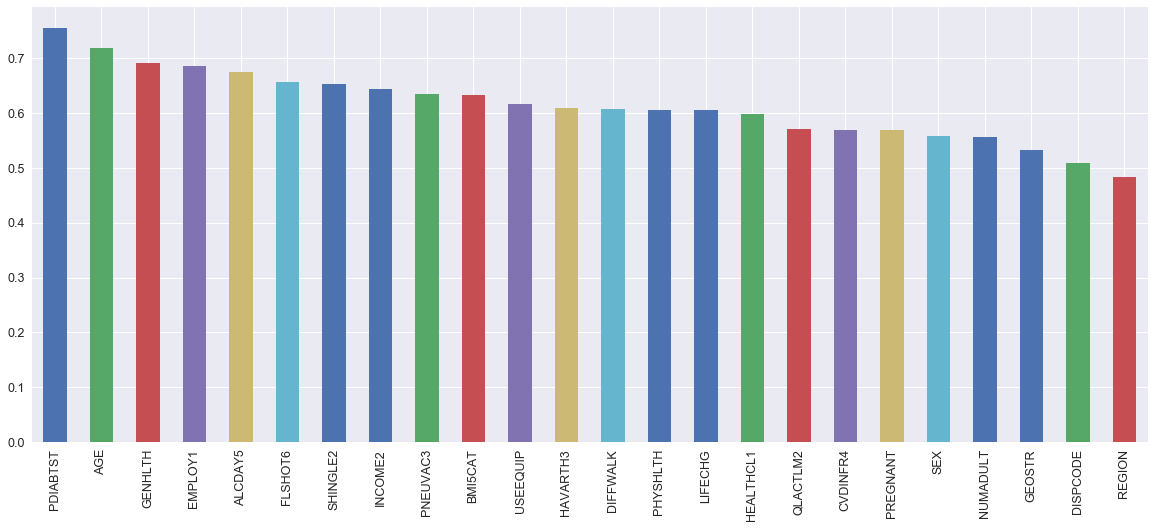

In [156]:
# let's add the variable names and order it for clearer visualisation
roc_values = pd.Series(roc_values)
roc_values.index = X_train.columns
roc_values.sort_values(ascending=False).plot.bar(figsize=(20, 8))

In [157]:
# by removing features with univariate roc_auc == 0.5
# we remove another 1 feature
 
selected_feat = roc_values[roc_values>0.5]
len(selected_feat), X_train.shape[1]

(23, 24)

#### 3.6 Select features by the regression coefficients

In [158]:
# Scaling features for the regression model
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [159]:
# select features using the coefficient of a non
# regularised logistic regression
 
sel_ = SelectFromModel(LogisticRegression(C=1000))
sel_.fit(scaler.transform(X_train), y_train)
 
# remove features with zero coefficient from dataset
# and parse again as dataframe (output of sklearn is
# numpy array)
X_train_coef = pd.DataFrame(sel_.transform(X_train))
X_test_coef = pd.DataFrame(sel_.transform(X_test))
 
# add the columns name
X_train_coef.columns = X_train.columns[(sel_.get_support())]
X_test_coef.columns = X_train.columns[(sel_.get_support())]

In [160]:
X_train_coef.shape, X_test_coef.shape

((1347, 5), (337, 5))

## Section 4 : Compare the performance in machine learning algorithms

In [161]:
# create a function to build random forests and compare performance in train and test set
 
def run_randomForests(X_train, X_test, y_train, y_test):
    rf = RandomForestClassifier(n_estimators=200, random_state=39, max_depth=4)
    rf.fit(X_train, y_train)
    print('Train set')
    pred = rf.predict_proba(X_train)
    print('Random Forests roc-auc: {}'.format(roc_auc_score(y_train, pred[:,1])))
    print('Test set')
    pred = rf.predict_proba(X_test)
    print('Random Forests roc-auc: {}'.format(roc_auc_score(y_test, pred[:,1])))

In [162]:
# original data set
run_randomForests(X_train_original,
                  X_test_original,
                  y_train, y_test)

Train set
Random Forests roc-auc: 0.9481565093166606
Test set
Random Forests roc-auc: 0.9359543436905516


In [163]:
# filter methods - basic
run_randomForests(X_train_basic_filter,
                  X_test_basic_filter,
                  y_train, y_test)


Train set
Random Forests roc-auc: 0.948368151394633
Test set
Random Forests roc-auc: 0.9347917987740436


In [164]:
# filter methods - correlation
run_randomForests(X_train_corr,
                  X_test_corr,
                  y_train, y_test)


Train set
Random Forests roc-auc: 0.9396136650235011
Test set
Random Forests roc-auc: 0.9186923131120975


In [165]:
# filter methods - univariate roc-auc
run_randomForests(X_train[selected_feat.index],
                  X_test_corr[selected_feat.index],
                  y_train, y_test)


Train set
Random Forests roc-auc: 0.9405263714847574
Test set
Random Forests roc-auc: 0.9218628901571196


In [166]:
# embedded methods - Logistic regression coefficients
run_randomForests(X_train_coef,
                  X_test_coef,
                  y_train, y_test)

Train set
Random Forests roc-auc: 0.9422591909981569
Test set
Random Forests roc-auc: 0.9347565701402099


#### Note:
Selecting features using the logistic regression coefficients gives the best performance except for the model with features from the original model. However, keep in mind that the model with the original features uses 92 features vs the only 5 used by the coefficients selection method. This means that many of those 92 features are still redundant, and we could potentially reduce the feature space further without loosing performance significantly.

## Section 5 : Extension of Logistic regression coefficients Model - Xgboost Model

In [182]:
xgb_model = xgb.XGBClassifier()

eval_set = [(X_test_coef, y_test)]
xgb_model.fit(X_train_coef, y_train, eval_metric="auc", eval_set=eval_set, verbose=False)

pred = xgb_model.predict_proba(X_train_coef)
print('xgb train roc-auc: {}'.format(roc_auc_score(y_train, pred[:,1])))
pred = xgb_model.predict_proba(X_test_coef)
print('xgb test roc-auc: {}'.format(roc_auc_score(y_test, pred[:,1])))

xgb train roc-auc: 0.9482116244411327
xgb test roc-auc: 0.942806312971183


In [183]:
fpr, tpr, thresholds = metrics.roc_curve(y_test,pred[:,1])


#### 5.1 Drawing ROC Curve - Xgboost Model

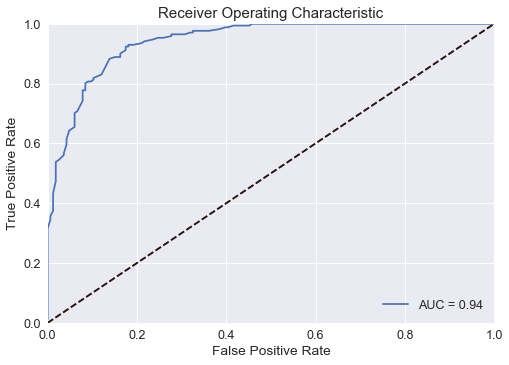

In [184]:
roc_auc = auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.plot([0, 1], [0, 1], 'k--', label='Baseline')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#### 5.2 Confusion Matrix and Classification Report -  Xgboost model with features extracted with Logistic regression coefficients

In [185]:
# Making the Confusion Matrix - Logistic regression coefficients Model

print(confusion_matrix(y_test, pred[:,1].round()))
print(classification_report(y_test,pred[:,1].round()))

[[141  25]
 [ 19 152]]
             precision    recall  f1-score   support

          0       0.88      0.85      0.87       166
          1       0.86      0.89      0.87       171

avg / total       0.87      0.87      0.87       337



#### 5.3 Calculating Lift Score
Lift measures the degree to which the predictions of a classification model are better than randomly-generated predictions.

In [186]:
from mlxtend.evaluate import lift_score
lift_score(y_test, pred[:,1].round())

1.692404268675455

#### 5.4 K-Fold Validation - xgboost

In [191]:
# Applying k-Fold Cross Validation
scores = cross_val_score(estimator = xgb_model, X = X_test_coef, y = y_test, cv = 10, scoring='roc_auc')
print('mean roc-auc is: {}' .format(scores.mean()))
print('standard deviation of roc-auc is: {}' .format(scores.std()))

mean roc-auc is: 0.9405360918877357
standard deviation of roc-auc is: 0.0490477416520166


#### 5.5 Feature of importance

In [188]:
vars = X_test_coef.columns

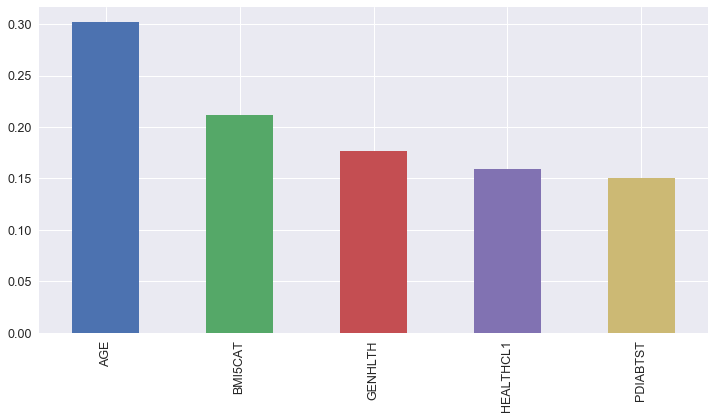

In [189]:
importance = pd.Series(xgb_model.feature_importances_)
importance.index = vars
importance.sort_values(inplace=True, ascending=False)
importance.plot.bar(figsize=(12,6))

#### 5.6 Conclusion
The Xgboost model gives a slighly better predictive performance than the Random Forest model ( roc-auc = **93.48** vs roc-auc = **94.28**). Also, the Xgboost model yields an overall accuracy of **87%** with precision and recall of **86%** and **89% ** respectively. In addition, note that the Xgboost model has a lift of approx. 1.69, which means that the predictions of this classification is 1.69 times better than randomly-generated predictions. Also worthy of note is the fact that the roc-auc of the 10-fold validation model is approx. **94%** and the dimensionality of the dataset (i.e. the feature space) has been significantly reduced, from 120 features to 5 features.
Notably the 5 most important predictors of whether a person has diabetes or not in order of importance are given below :
1. AGE - Age of the respondent?
2. BMI5CAT - Computed body mass index categories?
3. GENHLTH - Would you say that in general your health is ?
4. HEALTHCL1 - (You said that a medical professional has told you that you have or have had a chronic illness. During the last 12   months, have you taken a course or class to teach you about how to manage problems related to (this/these) chronic illness(es)?
Have you ever attended a lifestyle change program, such as the diabetes Prevention Program, in order to improve your health or prevent diabetes?)
5. PDIABTST - Had a test for high blood sugar in past three years?
